<a href="https://colab.research.google.com/github/BenWilliams2109/introduction-to-machine-learning/blob/main/comp88_lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMP0088 Lab Assignment 2



## Introduction


In this week's session you are asked to implement the fitting of **linear models** for **regression** (using the normal equations) and **classification** (using gradient descent). You will also apply **basis expansion** to fit a **polynomial** using linear regression.

Some examples of the sort of graphical outputs that should be generated once your code is implemented are given below. Plotting code is provided, so your plots should look pretty similar, although there may be quite a bit of random variation in the data.

![example of completed plots](https://comp0088.github.io/assets/colab/week_2_small.jpg)

Hopefully you are somewhat familiar with using Colab after last week's lab, but all the same points apply. In particular, remember that code edits do not automatically update to the notebook environment, you need to **run the cell** again to make them available.


## Setting Up

As usual, this notebook makes use of the NumPy library for numerical computing and the Matplotlib library for plotting, so we need to import them.

In [147]:
import numpy as np
import numpy.random
import matplotlib
import matplotlib.pyplot as plt

# this is probably the default, but just in case
%matplotlib inline

We'll also bring in the COMP0088 `utils` module from GitHub:

In [148]:
# load lab code and resources
!git clone https://github.com/comp0088/shared.git comp0088

# at the moment this is all we care about
import comp0088.utils as utils

fatal: destination path 'comp0088' already exists and is not an empty directory.


The following functions for data generation are just copied from the solutions to last week's lab. Feel free to substitute your own versions! We'll use these to produce data to be used for learning this week.

In [149]:
def generate_noisy_linear(num_samples, weights, sigma, limits, rng):
    return utils.random_sample(lambda x: utils.affine(x, weights),
                               len(weights) - 1,
                               num_samples, limits, rng, sigma)

def generate_linearly_separable(num_samples, weights, limits, rng):
    def hyperplane_label(X, boundary):
        y = utils.affine(X, boundary)
        return (y > 0).astype(np.float64)

    return utils.random_sample(lambda x: hyperplane_label(x, weights),
                               count = len(weights) - 1,
                               num_samples = num_samples,
                               limits = limits,
                               rng = rng)

In [150]:
# finally, set up some items for use in later code
shared_rng = numpy.random.default_rng()

WEIGHTS = np.array([0.5, -0.4, 0.6])
LIMITS = (-5, 5)

# Task 1: Ridge regression

Ridge regression is an extension of ordinary least squares (OLS) regression with a regularising penalty on the (squared) $L_2$ norm of the fitted weights. That is, given inputs $\mathbf{X}$ and corresponding outputs $\mathbf{y}$, we seek a vector $\mathbf{w}^{\star}$ such that:

$$
\mathbf{w}^{\star}  = \text{argmin}_{\mathbf{w}} \left\| \mathbf{Xw - y} \right\|^2 + \lambda \left\| \mathbf{w} \right\|^2
$$

where $\lambda$ is a hyperparameter that specifies the amount of regularisation. When $\lambda = 0$ the problem reduces to OLS.

Unlike many machine learning optimisations, ridge regression can be solved in closed form:

$$
\mathbf{w}^{\star} = (\mathbf{X}^{\mathsf{T}} \mathbf{X} + \lambda \mathbf{I})^{-1} \mathbf{X}^{\mathsf{T}} \mathbf{y}
$$

Note that this solution requires computing a matrix inverse, which can be computationally expensive. So a numerical optimisation approach may still be preferable for larger problems.


## 1.1 Implement ridge regression in closed form

Implement the body of the `ridge_closed` function in the cell below.

The NumPy function [`linalg.inv`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.inv.html) can be used to find the inverse of a matrix, though if you can rearrange the problem in suitable form for [`linalg.solve`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.solve.html) that is likely to be more efficient and numerically stable.

Note that both functions will fail if the problem is underdetermined. The [pseudo-inverse](https://en.wikipedia.org/wiki/Moore–Penrose_inverse) calculated by [`linalg.pinv`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.pinv.html) may be useful in that case, but you can assume it is not required here.

The driver code below will plot fits to the same data using multiple regularisation weights. The sample data itself is randomly generated using a noisy linear model function like the one you wrote last week, so the data will differ each time you run. How do variations in the data affect the fits?

In [151]:
def ridge_closed ( X, y, l2=0 ):
    """
    Implement L2-penalised least-squares (ridge) regression
    using its closed form expression.

    # Arguments
        X: an array of sample data, where rows are samples
           and columns are features (assume there are at least
           as many samples as features). caller is responsible
           for prepending x0=1 terms if required.
        y: vector of measured (or simulated) labels for the samples,
           must be same length as number of rows in X
        l2: optional L2 regularisation weight. if zero (the default)
           then this reduces to unregularised least squares

    # Returns
        w: the fitted vector of weights
    """
    assert(len(X.shape)==2)
    assert(X.shape[0]==len(y))

    in_brackets = np.linalg.inv(np.matmul(np.transpose(X), X) + l2*np.identity(X.shape[1]))

    # TODO: implement this
    return np.matmul(np.matmul(in_brackets, np.transpose(X)), y)

## → Run Task 1

Execute the code cell below to run your ridge regression on some generated data and plot the results.

Try playing with different values for `NUM_SAMPLES` and `SIGMA` and see how this affects the fit results.

If you are feeling completist, have a look at the code for `plot_ridge_regression_1d`. Do you notice anything problematic about it? (This is not a question about software engineering or code style!)

true weights: 0.50, -0.40, 0.60
regressed weights: 0.35, -0.38, 0.68
squared error: 0.03
plotting regularised least squares


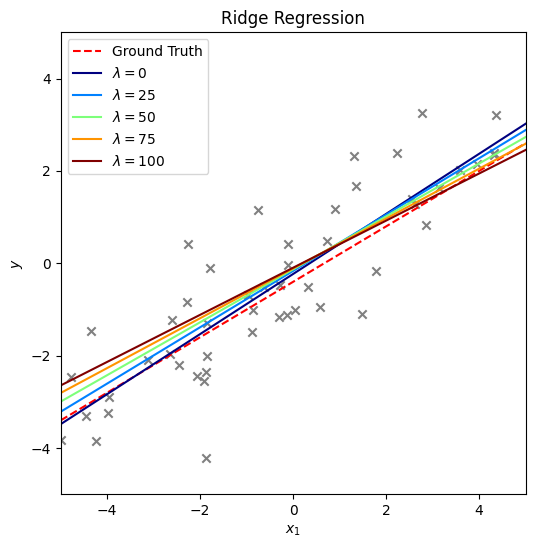

In [153]:
def plot_ridge_regression_1d ( axes, X, y, weights, limits, l2s=[0] ):
    """
    Perform least-squares fits to the provided (X, y) data
    using the specified levels of L2 regularisation, and plot
    the results.

    # Arguments
        axes: a Matplotlib Axes object into which to plot
        X: an array of sample data, where rows are samples
            and the single column is the input feature.
        y: vector of output values corresponding to the
            rows of X
        weights: a weight vector of length 2, specifying
            the true generating model, with a bias term
            at index 0.
        limits: a tuple (low, high) specifying the value
            range of the feature dimension x1
        l2s: a list (or vector/array) of numeric values
            specifying amounts of L2 regularisation to use.
    """
    assert(len(X.shape)==2)
    assert(X.shape[1]==1)
    assert(X.shape[0]==len(y))

    # plot the data
    axes.scatter(X[:,0], y, marker='x', color='grey')

    # plot the true relationship
    y0 = weights[0] + limits[0] * weights[1]
    y1 = weights[0] + limits[1] * weights[1]

    axes.plot(limits, (y0, y1), linestyle='dashed', color='red', label='Ground Truth')

    # fit for specified regs and plot the results
    X1 = utils.add_x0(X)

    cmap = matplotlib.colormaps['jet']
    for l2 in l2s:
        w = ridge_closed(X1, y, l2)

        y0 = w[0] + limits[0] * w[1]
        y1 = w[0] + limits[1] * w[1]

        axes.plot(limits, (y0, y1), linestyle='solid', color=cmap(l2/np.max(l2s)), label='$\lambda=%.f$' % l2)

    axes.set_xlim(limits[0], limits[1])
    axes.set_ylim(limits[0], limits[1])
    axes.set_xlabel('$x_1$')
    axes.set_ylabel('$y$')

    axes.legend(loc='upper left')

    axes.set_title('Ridge Regression')

NUM_SAMPLES = 50
SIGMA = 1

fig = plt.figure(figsize=(6, 6))
axs = fig.subplots()

X, y = generate_noisy_linear(NUM_SAMPLES, WEIGHTS, SIGMA, LIMITS, shared_rng)

# note that here we are using the default l2=0, so this is unregularised OLS
w = ridge_closed(utils.add_x0(X), y)

print('true weights: %.2f, %.2f, %.2f' % (WEIGHTS[0], WEIGHTS[1], WEIGHTS[2]))

if w is None:
    print('regression not implemented')
    utils.plot_unimplemented(axs, title='Ridge Regression')
else:
    print('regressed weights: %.2f, %.2f, %.2f' % (w[0], w[1], w[2]))
    print('squared error: %.2g' % np.dot(WEIGHTS-w, WEIGHTS-w))

    print('plotting regularised least squares')
    X, y = generate_noisy_linear(NUM_SAMPLES, WEIGHTS[1:], SIGMA, LIMITS, shared_rng)
    plot_ridge_regression_1d ( axs, X, y, WEIGHTS[1:], LIMITS, np.arange(5) * 25 )


# Task 2: Linear models with basis expansion

Ridge regression and similar linear fitting approaches only require that the outputs are linear in the *parameters*. Fixed transformations of the inputs may be performed to fit *non-linear* functions of the *data*. The transformed data can be considered as a projection of the original samples into a new higher dimensional feature space.

For example, a **monomial basis** comprises the *products* of the source features (including with themselves). For a 1D feature space, the products are just the powers of that single feature, ie: $x \mapsto [ x^0, x^1, x^2, ..., x^k ]$ for some maximum degree $k$. A polynomial is just a weighted sum of monomial terms---that is, a vector in the monomial basis, which we can linearly fit.




## 2.1 Map 1D feature vectors to a monomial basis

Implement the `monomial_projection_1d` function below.


In [154]:
def monomial_projection_1d ( X, degree ):
    """
    Map 1d data to an expanded basis of monomials
    up to the given degree.

    # Arguments
        X: an array of sample data, where rows are samples
            and the single column is the input feature.
        degree: maximum degree of the monomial terms

    # Returns
        Xm: an array of the transformed data, with the
            same number of rows (samples) as X, and
            with degree+1 columns (features):
            1, x, x**2, x**3, ..., x**degree
    """
    assert(len(X.shape)==2)
    assert(X.shape[1]==1)

    # TODO: implement this
    return [x**y for y,x in enumerate(X)]

## 2.2 Generate noisy 1D polynomial data

Provide code to implement the function `generate_noisy_poly_1d` below.

This function is obviously quite similar to `generate_noisy_linear` from week 1. Note that `weights` includes a bias term, so the monomial degree will be 1 less than its length.

In [ ]:
def generate_noisy_poly_1d ( num_samples, weights, sigma, limits, rng ):
    """
    Draw samples from a 1D polynomial model with additive
    Gaussian noise.

    # Arguments
        num_samples: number of samples to generate
            (ie, the number of rows in the returned X
            and the length of the returned y)
        weights: vector of the polynomial coefficients
            (including a bias term at index 0)
        sigma: standard deviation of the additive noise
        limits: a tuple (low, high) specifying the value
            range for the single input dimension x1
        rng: an instance of numpy.random.Generator
            from which to draw random numbers

    # Returns
        X: a matrix of sample inputs, where
            the samples are the rows and the
            single column is the 1D feature x1
            ie, its size should be:
              num_samples x 1
        y: a vector of num_samples output values
    """
    # TODO: implement this
    return None, None

## 2.3 Implement linear fitting of a 1D polynomial

Complete the implementation of the `fit_poly_1d` function in the cell below. Use your `monomial_projection_1d` function to transform the data and your `ridge_closed` implementation from Task 1 to perform the fitting.

In [ ]:
def fit_poly_1d ( X, y, degree, l2=0 ):
    """
    Fit a polynomial of the given degree to 1D sample data.

    # Arguments
        X: an array of sample data, where rows are samples
            and the single column is the input feature.
        y: vector of output values corresponding to the inputs,
           must be same length as number of rows in X
        degree: degree of the polynomial
        l2: optional L2 regularisation weight

    # Returns
        w: the fitted polynomial coefficients
    """
    assert(len(X.shape)==2)
    assert(X.shape[1]==1)
    assert(X.shape[0]==len(y))

    # TODO: implement this
    return None

## → Run Task 2

Execute the code cell below to run the function you wrote above and generate a plot.

As in Task 1, try playing with different values for `NUM_SAMPLES` and `SIGMA` and see how this affects the fit results.

In [ ]:
def plot_poly_fit_1d ( axes, X, y, weights, limits, degrees, l2=0 ):
    """
    Fit polynomials of different degrees to the supplied
    data, and plot the results.

    # Arguments
        axes: a Matplotlib Axes object into which to plot
        X: an array of sample data, where rows are samples
            and the single column is the input feature.
        y: vector of output values corresponding to the inputs,
           must be same length as number of rows in X
        weights: the true polynomial coefficients from which
           the data was generated
        limits: a tuple (low, high) specifying the value
            range of the feature dimension x1
        degrees: a list of integer values specifying degrees
            of polynomial to fit
        l2: the amount of l2 regularisation to apply

    # Returns
        None
    """
    assert(len(X.shape)==2)
    assert(X.shape[1]==1)
    assert(X.shape[0]==len(y))

    axes.scatter(X, y, color='grey', marker='x')

    print(f'true weights: {weights}')
    ground_x, ground_y = utils.grid_sample(lambda x: utils.affine(monomial_projection_1d(x, len(weights)-1), weights),
                                           1,
                                           num_divisions=50, limits=limits)

    axes.plot(ground_x, ground_y, color='red', linestyle='dashed', label='Ground Truth')

    cmap = matplotlib.colormaps['jet']
    n = 0
    for deg in degrees:
        w = fit_poly_1d(X, y, deg, l2)

        if w is None:
            print('Polynomial fitting not implemented')
            break

        print(f'fit {deg} weights: {w}')
        fit_x, fit_y = utils.grid_sample(lambda x: utils.affine(monomial_projection_1d(x, len(w)-1), w),
                                         1,
                                         num_divisions=50, limits=limits)
        axes.plot(fit_x, fit_y, linestyle='solid', color=cmap(n/len(degrees)), label=f'Degree {deg} Fit')
        n += 1

    axes.set_xlim(limits[0], limits[1])
    axes.set_xlabel('$x_1$')
    axes.set_ylabel('$y$')

    axes.legend(loc='upper right')

    axes.set_title('Polynomial Fitting')

NUM_SAMPLES = 50
SIGMA = 3

fig = plt.figure(figsize=(6, 6))
ax = fig.subplots()

X, y = generate_noisy_poly_1d ( NUM_SAMPLES, WEIGHTS, SIGMA, LIMITS, shared_rng )
if X is None:
    print('poly generation not implemented')
    utils.plot_unimplemented(ax, title='Polynomial Fitting')
else:
    plot_poly_fit_1d ( ax, X, y, WEIGHTS, LIMITS, [1, 2, 3, 4], 0 )

# Task 3: Gradient descent

**Gradient descent** is an iterative numerical method for solving optimisation problems where an analytic solution is unavailable or impractical. It is the basis for a family of closely-related methods that are very widely applied in ML and deep learning.

The basic procedure is shown in pseudocode form below; we might facetiously summarise it as "walk downhill".

```
function GradientDescent( f, z0, alpha )
    f: the function to be minimised
    z0: an initial value for the function parameter vector z
    alpha: some small step size, known as the learning rate

    z = z0
    repeat:
      z -= alpha * Gradient(f, z)
    until (some stopping criterion reached)
    return z
```

Note the following:

* The algorithm requires the gradient of the function with respect to the parameters, `Gradient(f, z)`, to be calculable, so `f` must be (more or less) continuous and differentiable. (There can be scope for fudging over known undefined points -- see the lasso regularisation task in Further Exploration.)
* Only local information is used at each step, so the process can get stuck in local minima if `f` is not convex.
* There is a hyperparameter `alpha` that must be chosen somehow, which may have a significant effect on how long the process takes to converge (or whether it does at all).
* When the gradient is shallow, convergence might be very slow.




## 3.1 Implement a generic gradient descent optimiser

Provide an implementation of the `gradient_descent` function in the cell below. It receives function objects for both the function to be minimised and its gradient and should repeat the process until any of the convergence criteria are reached.

Note that the returned values are lists documenting the *history* of the optimisation.


In [ ]:
def gradient_descent ( z, loss_func, grad_func, lr=0.01,
                       loss_stop=1e-4, z_stop=1e-4, max_iter=100 ):
    """
    Generic batch gradient descent optimisation.
    Iteratively updates z by subtracting lr * grad
    until one or more stopping criteria are met.

    # Arguments
        z: initial value(s) of the optimisation var(s).
            can be a scalar if optimising a univariate
            function, otherwise a single numpy array
        loss_func: function of z that we seek to minimise,
            should return a scalar value
        grad_func: function calculating the gradient of
            loss_func at z. for vector z, this should return
            a vector of the same length containing the
            partial derivatives
        lr: learning rate, ie fraction of the gradient by
            which to update z each iteration
        loss_stop: stop iterating if the loss changes
            by less than this (absolute)
        z_stop: stop iterating if z changes by less than
            this (L2 norm)
        max_iter: stop iterating after iterating this
            many times

    # Returns
        zs: a list of the z values at each iteration
        losses: a list of the losses at each iteration
    """
    # TODO: implement this
    return None, None

## → Run Task 3

Execute the cell below to test your implementation.

Although our ultimate goal for gradient descent is to fit the parameters of machine learning models from potentially noisy data, the algorithm can be used to minimise any reasonably well-behaved function for which the gradient can be calculated. The test code applies it to a simple quadratic function,

$$
f(x) = x^2 - 2x + 1
$$

for which the gradient is trivially derived,

$$
f^\prime(x) = 2x - 2
$$

and we can see that the function reaches a minimum of 0 at $x=1$. Check that your gradient descent implementation manages to adequately estimate this result.

In [ ]:
xx, ll = gradient_descent ( 10,
                            lambda x: x * x - 2 * x + 1,
                            lambda x: 2 * x - 2,
                            lr=0.1,
                            loss_stop=1e-6,
                            z_stop=1e-6 )

print(f'Minimum value found after {len(xx)} iterations: {xx[-1]:.4f}')
print(f'Final loss value: {ll[-1]}')

# Task 4: Logistic regression

Logistic regression is an adaptation of linear regression for binary classification. It fits a linear decision boundary between two classes using a **sigmoid** transformation of the output value that maps it from $(-\infty, +\infty)$ to $(0, 1)$:

$$
\hat{\mathbf{y}} = \sigma(\mathbf{Xw})
$$

where $\sigma$ is the **logistic function**:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

The predictions $\hat{\mathbf{y}}$ are evaluated against the true labels $\mathbf{y}$ using a **binary cross-entropy** loss:

$$
L(\mathbf{y}, \hat{\mathbf{y}}) = -\frac{1}{n} \; \Bigg[ \; \mathbf{y} \cdot \log(\hat{\mathbf{y}}) + (1 - \mathbf{y}) \cdot \log(1 - \hat{\mathbf{y}}) \; \Bigg]
$$

(The loss is expressed here using dot product notation rather than the more common summation, but the two are equivalent and this representation lends itself to a concise implementation in NumPy.)

Unlike for ridge regression, there is no closed form expression for finding the $\mathbf{w}$ that minimises this loss, and we must instead optimise numerically. Luckily, the loss function is differentiable and convex, so gradient descent is a reasonable approach. (Other algorithms are also available that may converge faster, but we won't worry about that here.)

As shown in the lectures, the gradient of the loss with respect to $\mathbf{w}$ is:

$$
\nabla_{\mathbf{w}}L = \mathbf{X}^{\mathsf{T}} (\hat{\mathbf{y}} - \mathbf{y})
$$

## 4.1 Implement logistic regression

Provide an implementation body for the `logistic_regression` function defined in the cell below.

Use the `gradient_descent` function from Task 3 to do the optimisation.

You will need to provide functions for the loss and gradient that take only the weights vector as their argument. (Remember that the training data is constant as far as parameter fitting is concerned.)

One thing to note when implementing this is that errors are likely to arise from trying to take the logarithm of zero. Strictly, the logistic function is never quite 0 or 1, but it gets *really* close. You will probably find it helpful to add a small offset value to $\hat{\mathbf{y}}$ and $1 - \hat{\mathbf{y}}$ when calculating the loss.



In [ ]:
def logistic_regression ( X, y, w0=None, lr=0.05,
                          loss_stop=1e-4, weight_stop=1e-4, max_iter=100 ):
    """
    Fit a logistic regression classifier to data.

    # Arguments
        X: an array of sample data, where rows are samples
           and columns are features. caller is responsible
           for prepending x0=1 terms if required.
        y: vector of binary class labels for the samples,
           must be same length as number of rows in X
        w0: starting value of the weights, if omitted
           then all zeros are used
        lr: learning rate, ie fraction of gradients by
           which to update weights at each iteration
        loss_stop: stop iterating if the loss changes
            by less than this (absolute)
        weight_stop: stop iterating if weights change by less
            than this (L2 norm)
        max_iter: stop iterating after iterating this
            many times

    # Returns
        ws: a list of fitted weights at each iteration
        losses: a list of the loss values at each iteration
    """
    assert(len(X.shape)==2)
    assert(X.shape[0]==len(y))

    # TODO: implement this
    return None, None


## → Run Task 4

Execute the code cell below to run the function you wrote in the previous cell and produce plots showing the loss history and eventual solution.


In [ ]:
def plot_logistic_regression_2d ( axs, X, y, weights, limits ):
    """
    Fit a 2D logistic regression classifier and plot the results.
    Note that there are two separate plots produced here.
    The first (in axs[0]) is an optimisation history, showing how the
    loss decreases via gradient descent. The second (in axs[1]) is
    the regression itself, showing data points and fit results.

    # Arguments
        axs: an array of 2 Matplotlib Axes objects into which
           to plot.
        X: an array of sample data, where rows are samples
           and columns are features, including x0=1 terms.
        y: vector of binary class labels for the samples,
           must be same length as number of rows in X
        weights: weights defining the true decision boundary
           with which the data was generated
        limits: a tuple (low, high) specifying the value
            range of both feature dimensions

    # Returns
        None
    """
    assert(len(X.shape)==2)
    assert(X.shape[1]==3)
    assert(X.shape[0]==len(y))
    assert(len(weights)==3)

    ww, ll = logistic_regression(X, y)
    if ww is None:
        utils.plot_unimplemented(axs[0], title='Logistic Regression Gradient Descent')
        utils.plot_unimplemented(axs[1], title='Logistic Regression Results')
        return

    print('Number of iterations: %i' % len(ll))
    axs[0].plot(ll)
    axs[0].set_title('Logistic Regression Gradient Descent')
    axs[0].set_xlabel('Iteration')
    axs[0].set_ylabel('Logistic Loss')

    Xm, ym = utils.grid_sample(lambda x: 1/(1 + np.exp(-utils.affine(x, ww[-1]))), 2, 100, limits)
    axs[1].imshow(ym.T, cmap='coolwarm', origin='lower', extent=(limits[0], limits[1], limits[0], limits[1]), alpha=0.5)
    axs[1].contour(ym.T, levels=[.5], origin='lower', extent=(limits[0], limits[1], limits[0], limits[1]))

    y0 = -(weights[0] + limits[0] * weights[1]) / weights[2]
    y1 = -(weights[0] + limits[1] * weights[1]) / weights[2]

    axs[1].plot(limits, (y0, y1), linestyle='dashed', color='red', marker='')

    axs[1].plot(X[y==0,1], X[y==0,2], linestyle='', color='orange', marker='v', label='Class 0')
    axs[1].plot(X[y==1,1], X[y==1,2], linestyle='', color='darkorchid', marker='o', label='Class 1')

    axs[1].set_xlabel('$x_1$')
    axs[1].set_ylabel('$x_2$')

    axs[1].legend(loc='upper left', framealpha=1)

    axs[1].set_title('Logistic Regression Results')


fig = plt.figure(figsize=(9, 4.5))
axs = fig.subplots(ncols=2)

NUM_SAMPLES = 50

X, y = generate_linearly_separable(NUM_SAMPLES, WEIGHTS, LIMITS, shared_rng)
X0 = utils.add_x0(X)
plot_logistic_regression_2d(axs, X0, y, WEIGHTS, LIMITS)

fig.tight_layout(pad=1)

This code uses the following function as a test case:

\begin{equation}
y = (x_1 - 1)^2 + x_2^2 + \big| 2 (x_1 - 1) x_2 \big|
\end{equation}

It can be seen by inspection that this function has its minimum at $(1, 0)$, and this value is passed as `true_min`. How does this compare to the values discovered by the grid and random searches? How consistent is that if you re-run the test several times? Looking at the parameters with which the script calls `plot_searches_2d`, how might you estimate the probability that random search outperforms grid search here?


# Further exploration

If you have exhausted the previous exercises, you might find it interesting to try out one or more of the following challenges. Doing so is entirely optional, but may provide some additional perspective that could be useful in the weeks ahead.

## Implement lasso regression using gradient descent

The loss function for **lasso** ($L_1$ regularised least squares) looks like this:

$$
L(\mathbf{X, y, w}) = \|\mathbf{Xw - y}\|^2 + \lambda \| \mathbf{w} \|_1
$$

The $L_1$ norm has a corner at zero, so this function is not strictly differentiable. However, it is easy to define a **subgradient** for the norm at this point -- this could be any value in the interval $[-1, 1]$, but since this really *is* its minimum point the obvious choice is 0.

Armed with this subgradient, you should be able to implement the lasso loss and gradient functions and fit a lasso model by gradient descent. How do the results of such a fit compare with those from ridge regression?


## Implement multinomial logistic regression using gradient descent

As discussed in the lectures, the binary classification model of logistic regression can be adapted for multiclass problems using **softmax** squashing and a **categorical cross-entropy** loss. The model becomes:

$$
\hat{\mathbf{Y}} = \mathbf{\varsigma}(\mathbf{XW})
$$

where $\mathbf{\varsigma}$ is the softmax function:

$$
\mathbf{\varsigma}(\mathbf{z}) = \frac{e^{\mathbf{z}}}{\|e^{\mathbf{z}}\|_1}
$$

with exponentiation performed elementwise. The loss is:

$$
L(\mathbf{Y, \hat{Y}}) = -\frac{1}{n} \sum_i^n \mathbf{y}_i \cdot \log(\hat{\mathbf{y}}_i) = \frac{1}{n} \Big\| \mathbf{Y}^\mathsf{T}\log(\hat{\mathbf{Y}}) \Big\|_1
$$

where the logs are similarly taken elementwise. The gradient is:

$$
\nabla_{\mathbf{W}}L = \mathbf{X}^{\mathsf{T}} (\hat{\mathbf{Y}} - \mathbf{Y})
$$

Fitting this via gradient descent is similar to binary logistic regression, but you will need to manage mapping ground truth values into one-hot vectors and prediction vectors back to class labels. And remember that $\mathbf{Y}$, $\hat{\mathbf{Y}}$ and $\mathbf{W}$ are all matrices.

Multinomial logistic regression can be applied to data with two classes, so you could test your implementation with synthetic data from the binary `generate_linearly_separable` function. But you'll probably want to try it with more than two classes. One good source of test data is the `sklearn.datasets` package from `scikit-learn`, which should already be installed in your Colab environment and ready to import. For example, have a look at the [`load_iris`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html) function for Fisher's classic [Iris](https://en.wikipedia.org/wiki/Iris_flower_data_set) dataset.


## Implement stochastic/mini-batch gradient descent

In Task 3 you implemented *batch* gradient descent, where the loss gradient is calculated with respect to the whole training set before updating the parameters. In *mini-batch* gradient descent, updates are applied more frequently using gradients estimated using only a fraction of the training set. If that fraction is just a single sample at a time, then it is known as *stochastic* gradient descent. (In practice this distinction is quite often glossed over and the term "stochastic gradient descent" applied for any mini-batch size.)

Try implementing mini-batch gradient descent with a configurable batch size and see how it behaves in comparison to the full batch version. (You will need to adapt the interfaces both for the optimiser and the loss functions to accept the training data.) Plot the loss history for all the mini-batch updates -- is it noticeably different to that for batch gradient descent? Does the batch size affect this?
